In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform


In [47]:

df = pd.read_csv('../data/IMDB Dataset_az.csv')
df = df[['review_az', 'sentiment']]
df.rename(columns={'review_az': 'text'}, inplace=True)
df.rename(columns={'sentiment': 'label'}, inplace=True)

In [48]:
def split_sentences(text):
    pattern = r'(?<=[.!?])\s*'
    sentences = re.split(pattern, text)
    sentences_with_whitespace = ' '.join(sentences)
    return sentences_with_whitespace

df['text'] = df['text'].apply(split_sentences)
df['text'] = df['text'].apply(lambda x: x.lower())

In [4]:
# Function to create term-document matrix
def create_term_document_matrix(documents):
    word_counts = Counter()
    for doc in documents:
        word_counts.update(doc.split())

    vocabulary = sorted(word_counts.keys())
    vocab_index = {word: i for i, word in enumerate(vocabulary)}

    matrix = np.zeros((len(vocabulary), len(documents)), dtype=np.int32)
    for doc_id, doc in enumerate(documents):
        for word in doc.split():
            matrix[vocab_index[word], doc_id] += 1

    return matrix, vocabulary

# Function to create word-word matrix
def create_word_word_matrix(documents):
    word_counts = Counter()
    for doc in documents:
        word_counts.update(doc.split())

    vocabulary = sorted(word_counts.keys())
    vocab_index = {word: i for i, word in enumerate(vocabulary)}

    matrix = np.zeros((len(vocabulary), len(vocabulary)), dtype=np.int32)
    for doc in documents:
        words = doc.split()
        for i in range(len(words)):
            for j in range(i+1, len(words)):
                word_i, word_j = words[i], words[j]
                matrix[vocab_index[word_i], vocab_index[word_j]] += 1
                matrix[vocab_index[word_j], vocab_index[word_i]] += 1

    return matrix, vocabulary

In [5]:
documents = df['text'].tolist()
term_doc_matrix, vocab_term_doc = create_term_document_matrix(documents)
word_word_matrix, vocab_word_word = create_word_word_matrix(documents)

# Visualize matrices
print("Term-Document Matrix:")
print(term_doc_matrix)
# print("\nWord-Word Matrix:")
print(word_word_matrix)

Term-Document Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[18206    12     3 ...     0     1     0]
 [   12     8     1 ...     0     0     0]
 [    3     1     2 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    1     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]


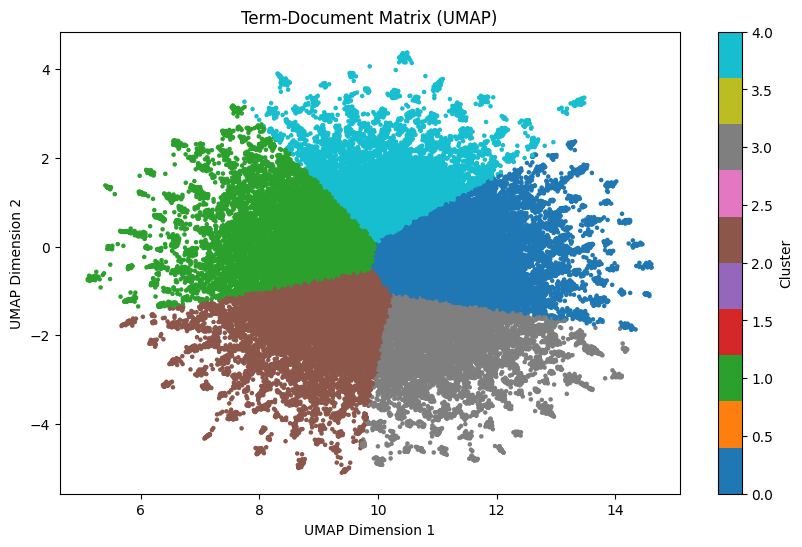

KeyboardInterrupt: 

In [10]:
import numpy as np
import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Assuming term_doc_matrix and word_word_matrix are your matrices

# Step 1: Apply dimensionality reduction to term-document matrix
reducer = umap.UMAP()
term_doc_embedding = reducer.fit_transform(term_doc_matrix)

# Step 2: Apply clustering to term-document matrix
kmeans = KMeans(n_clusters=5)  # You can adjust the number of clusters
term_doc_labels = kmeans.fit_predict(term_doc_embedding)

# Step 3: Visualize term-document matrix
plt.figure(figsize=(10, 6))
plt.scatter(term_doc_embedding[:, 0], term_doc_embedding[:, 1], c=term_doc_labels, cmap='tab10', s=5)
plt.title('Term-Document Matrix (UMAP)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster')
plt.show()

# Step 4: Apply dimensionality reduction to word-word matrix
word_word_embedding = reducer.fit_transform(word_word_matrix)

# Step 5: Apply clustering to word-word matrix
word_word_labels = kmeans.fit_predict(word_word_embedding)

# Step 6: Visualize word-word matrix
plt.figure(figsize=(10, 6))
plt.scatter(word_word_embedding[:, 0], word_word_embedding[:, 1], c=word_word_labels, cmap='tab10', s=5)
plt.title('Word-Word Matrix (UMAP)')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.colorbar(label='Cluster')
plt.show()


In [5]:
documents = df['text'].tolist()
term_doc_matrix, vocab_term_doc = create_term_document_matrix(documents)
word_word_matrix, vocab_word_word = create_word_word_matrix(documents)

# Visualize matrices
print("Term-Document Matrix:")
print(term_doc_matrix)
# print("\nWord-Word Matrix:")
print(word_word_matrix)

Term-Document Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[[18206    12     3 ...     0     1     0]
 [   12     8     1 ...     0     0     0]
 [    3     1     2 ...     0     0     0]
 ...
 [    0     0     0 ...     0     0     0]
 [    1     0     0 ...     0     0     0]
 [    0     0     0 ...     0     0     0]]


In [6]:
import numpy as np
from collections import Counter

# Assuming the functions and the document processing is already done and you have `word_word_matrix` and `vocab_word_word`

# Function to find top N frequent word pairs
def find_top_word_pairs(matrix, vocabulary, top_n=10):
    # Number of words in the vocabulary
    num_words = len(vocabulary)
    
    # Create a list to store word pairs and their frequencies
    word_pairs = []
    
    # Iterate through the matrix to get word pair frequencies
    for i in range(num_words):
        for j in range(i+1, num_words):  # Ensure j > i to avoid duplicates and diagonal
            if matrix[i, j] > 0:  # If the pair co-occurs at least once
                word_pairs.append(((vocabulary[i], vocabulary[j]), matrix[i, j]))
    
    # Sort the list of word pairs by frequency in descending order
    word_pairs.sort(key=lambda x: x[1], reverse=True)
    
    # Return the top N word pairs
    return word_pairs[:top_n]

# Get the top 10 most frequent word pairs
top_word_pairs = find_top_word_pairs(word_word_matrix, vocab_word_word, top_n=10)

# Display the top 10 word pairs and their frequencies
for pair, freq in top_word_pairs:
    print(f"{' & '.join(pair)}: {freq}")


KeyboardInterrupt: 

In [ ]:
term_doc_matrix, vocab_term_doc
word_word_matrix, vocab_word_word

In [8]:
term_doc_matrix.shape

(58550, 2000)

In [13]:
len(vocab_term_doc)

58550

In [14]:
word_word_matrix

array([[18206,    12,     3, ...,     0,     1,     0],
       [   12,     8,     1, ...,     0,     0,     0],
       [    3,     1,     2, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    1,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0]], dtype=int32)

In [16]:
len(vocab_word_word)

58550

In [43]:
def most_frequent_pairs(matrix, vocabulary, top_n=10):
    pair_frequencies = []
    # Loop over the upper triangle of the matrix to avoid duplicate pairs
    for i in range(len(vocabulary)):
        for j in range(i+1, len(vocabulary)):
            frequency = matrix[i, j]
            if frequency > 0:
                pair_frequencies.append(((vocabulary[i], vocabulary[j]), frequency))
    
    # Sort pairs by frequency in descending order
    most_frequent = sorted(pair_frequencies, key=lambda x: x[1], reverse=True)[:top_n]
    
    return most_frequent


In [44]:
def most_frequent_words(matrix, vocabulary, top_n=10):
    word_frequencies = np.sum(matrix, axis=1)
    word_freq_pairs = list(zip(vocabulary, word_frequencies))
    
    # Sort by frequency
    most_frequent = sorted(word_freq_pairs, key=lambda x: x[1], reverse=True)[:top_n]
    
    return most_frequent


In [49]:
# Example documents
documents = df['text'].tolist()

# Create matrices and vocabulary
term_doc_matrix, vocabulary = create_term_document_matrix(documents)
word_word_matrix, vocabulary = create_word_word_matrix(documents)

# Get most frequent pairs and words
most_frequent_pairss = most_frequent_pairs(word_word_matrix, vocabulary, top_n=100)
most_frequent_wordss = most_frequent_words(term_doc_matrix, vocabulary, top_n=100)

print("Most Frequent Word Pairs:")
for pair, freq in most_frequent_pairss:
    print(f"{pair}: {freq}")

print("\nMost Frequent Words:")
for word, freq in most_frequent_wordss:
    print(f"{word}: {freq}")

Most Frequent Word Pairs:
('bir', 'və'): 134401
('bir', 'bu'): 61222
('<br', 'bir'): 60807
('/>', 'bir'): 54624
('<br', 'və'): 52534
('bu', 'və'): 52059
('/>', 'və'): 47280
('bir', 'üçün'): 46534
('/>', '<br'): 45863
('və', 'üçün'): 40098
('bir', 'çox'): 34350
('və', 'çox'): 29609
('.', 'bir'): 26642
('<br', 'bu'): 26187
('bir', 'ilə'): 23996
('/>', 'bu'): 23591
('.', 'və'): 22816
('bir', 'kimi'): 22727
('bir', 'film'): 22208
('bir', 'ki,'): 21379
('ilə', 'və'): 20682
('bir', 'də'): 20145
('bir', 'daha'): 20006
('kimi', 'və'): 19766
('bu', 'üçün'): 19201
('bir', 'olan'): 18973
('<br', 'üçün'): 18885
('film', 'və'): 18785
('bir', 'yaxşı'): 18056
('bir', 'hər'): 17992
('də', 'və'): 17933
('ki,', 'və'): 17751
('daha', 'və'): 17296
('bir', 'ya'): 17249
('/>', 'üçün'): 17006
('bir', 'qədər'): 16952
('və', 'ya'): 15980
('olan', 'və'): 15897
('hər', 'və'): 15244
('bir', 'heç'): 15178
('və', 'yaxşı'): 15099
('bir', 'bu,'): 14962
('qədər', 'və'): 14459
('bir', 'ən'): 14105
('bu', 'çox'): 13695


In [45]:
""""
Most Frequent Word Pairs:
('bir', 'və'): 134401
('bir', 'bu'): 61222
('<br', 'bir'): 60807
('/>', 'bir'): 54624
('<br', 'və'): 52534

Most Frequent Words:
bir: 14476
və: 12408
bu: 6513
<br: 5997
/>: 5367
""""

SyntaxError: unterminated string literal (detected at line 15) (3788856265.py, line 15)

In [28]:
term_doc_matrix.shape

(58550, 2000)

In [38]:
term_doc_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [32]:
word_word_matrix

array([[18206,    12,     3, ...,     0,     1,     0],
       [   12,     8,     1, ...,     0,     0,     0],
       [    3,     1,     2, ...,     0,     0,     0],
       ...,
       [    0,     0,     0, ...,     0,     0,     0],
       [    1,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0]], dtype=int32)

In [33]:
vocabulary[:3]

['!', '"', '""']

In [35]:
vocabulary[-3:]

['əşyalarını', 'əşyalarının', 'əşyanın']

In [37]:
np.argmax(word_word_matrix)

582641001

In [ ]:

"""
Most Frequent Word Pairs:
('bir', 'və'): 134401
('bir', 'bu'): 61222
('bu', 'və'): 52059
('bir', 'üçün'): 46534
('və', 'üçün'): 40098
('bir', 'çox'): 34350
('və', 'çox'): 29609
('bir', 'ilə'): 23996
('bir', 'kimi'): 22727
('bir', 'film'): 22208
('bir', 'ki,'): 21379
('ilə', 'və'): 20682
('bir', 'də'): 20145
('bir', 'daha'): 20006
('kimi', 'və'): 19766
('bu', 'üçün'): 19201
('bir', 'olan'): 18973
('film', 'və'): 18785
('bir', 'yaxşı'): 18056
('bir', 'hər'): 17992
('də', 'və'): 17933
('ki,', 'və'): 17751
('daha', 'və'): 17296
('bir', 'ya'): 17249
('bir', 'qədər'): 16952
('və', 'ya'): 15980
('olan', 'və'): 15897
('hər', 'və'): 15244
('bir', 'heç'): 15178
('və', 'yaxşı'): 15099
('bir', 'bu,'): 14962
('qədər', 'və'): 14459
('bir', 'ən'): 14105
('bu', 'çox'): 13695
('və', 'ən'): 12726
('bu,', 'və'): 12508
('heç', 'və'): 12369
('bir', 'şey'): 11630
('.', '/>'): 11378
('bir', 'onun'): 11058
('bu', 'film'): 10683
('çox', 'üçün'): 10348
('amma', 'bir'): 9982
('ancaq', 'bir'): 9978
('onun', 'və'): 9905
('bir', 'sonra'): 9855
('-', 'bir'): 9560
('bu', 'ki,'): 9547
('bir', 'yalnız'): 9330
('bir', 'idi.'): 9327
('və', 'şey'): 9322
('bir', 'böyük'): 9118
('bir', 'filmin'): 9082
('bu', 'kimi'): 9012
('sonra', 'və'): 8922
('bu', 'ilə'): 8724
('ancaq', 'və'): 8596
('bir', 'filmi'): 8559
('bu', 'də'): 8365
('bir', 'onu'): 8333
('bir', 'etmək'): 8249
('bu', 'qədər'): 8249
('amma', 'və'): 8209
('bir', 'olduğunu'): 8182
('bir', 'bütün'): 8089
('bir', 'lakin'): 7957
('və', 'yalnız'): 7881
('idi.', 'və'): 7836
('bu', 'daha'): 7823
('bir', 'o,'): 7747
('böyük', 'və'): 7665
('filmin', 'və'): 7651

Most Frequent Words:
bir: 14476
və: 12408
bu: 6513
üçün: 4449
çox: 3260
film: 2364
ki: 2133
ilə: 2112
kimi: 2078
də: 1909
yaxşı: 1900
daha: 1864
qədər: 1714
hər: 1658
olan: 1623
ən: 1500
bu,: 1485
ya: 1432
heç: 1387
idi.: 1039
şey: 1039
amma: 1032
filmi: 997
onun: 950
ancaq: 948
-: 931
filmin: 909
yalnız: 903
sonra: 871
böyük: 863
pis: 851
bütün: 801
həqiqətən: 796
nə: 783
etmək: 759
olduğunu: 755
da: 729
lakin: 712
onu: 710
mən: 702
az: 661
tərəfindən: 637
var.: 630
o,: 626
şəkildə: 626
edir.: 607
!: 597
edən: 583
olduğu: 582
görə: 571
neçə: 559
başqa: 528
vaxt: 527
bəzi: 524
deyil.: 523
haqqında: 497
edə: 478
iki: 472
filmdə: 462
var: 459
bunu: 443
o: 441
sadəcə: 440
hərəkət: 439
çünki: 425
dəfə: 422
kimi,: 400
olaraq: 399
necə: 397
dəhşətli: 393
buna: 392
ola: 390
olduqca: 385
digər: 383
hekayə: 383
tamamilə: 377
baş: 376
deyil,: 376
gözəl: 370
biri: 368
idi: 364
istifadə: 363
ilk: 348
bunun: 341
hətta: 341
hansı: 337
son: 337
eyni: 331
həm: 327
hiss: 319
demək: 316
burada: 308
kiçik: 307
hələ: 306
zaman: 299
görmək: 297
bəlkə: 285
"""


In [51]:
word_word_matrix.shape

(58550, 58550)

In [52]:
term_doc_matrix.shape

(58550, 2000)

In [70]:
# put term_doc_matrix into pandas df rows are words and columns are documents
df_term_doc = pd.DataFrame(term_doc_matrix, index=vocab_term_doc)
# sort by the count of the word in all documents
df_term_doc['sum'] = df_term_doc.sum(axis=1)
df_term_doc = df_term_doc.sort_values(by='sum', ascending=False)
df_term_doc = df_term_doc.drop('sum', axis=1)
df_term_doc


,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
bir,15,22,3,8,8,11,7,3,0,8,...,5,12,9,12,6,3,3,6,10,2
və,11,28,6,4,1,7,7,0,1,3,...,6,10,8,14,6,2,4,4,16,6
bu,7,3,5,1,5,1,4,4,1,2,...,3,5,4,8,1,0,1,3,4,1
<br,12,0,2,6,0,1,5,2,1,6,...,7,3,0,38,2,3,0,11,12,0
/>,10,0,2,6,0,1,5,2,1,6,...,6,2,0,38,2,2,0,11,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hazırlanmasına,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hazırlanmasında,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hazırlanmayan,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"hazırlanmayan,",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
# also sort by the documents
df_term_doc = df_term_doc.T
df_term_doc['sum'] = df_term_doc.sum(axis=1)
df_term_doc = df_term_doc.sort_values(by='sum', ascending=False)
df_term_doc = df_term_doc.drop('sum', axis=1)
df_term_doc

,bir,və,bu,<br,/>,üçün,çox,.,film,"ki,",...,"hazırlandığını,",hazırlanmadı.,hazırlanmadı?,hazırlanmalı,hazırlanmalıdır!,hazırlanmasına,hazırlanmasında,hazırlanmayan,"hazırlanmayan,",əşyanın
385,19,17,11,37,36,12,7,9,3,9,...,0,0,0,0,0,0,0,0,0,0
730,21,30,20,15,13,6,11,6,4,4,...,0,0,0,0,0,0,0,0,0,0
201,32,20,12,6,6,18,9,13,1,5,...,0,0,0,0,0,0,0,0,0,0
1404,31,37,4,0,0,11,2,0,1,2,...,0,0,0,0,0,0,0,0,0,0
1965,31,28,7,16,13,9,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1499,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
358,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
# slice df from 100 to 200
df_term_doc.T.iloc[10:50, :20]


,385,730,201,1404,1965,116,1938,336,1044,1622,1709,1521,1381,840,822,1967,1061,553,1256,1759
ilə,1,7,7,6,5,7,2,2,9,3,4,1,2,1,4,3,8,2,2,3
kimi,4,11,2,3,1,3,2,2,4,1,5,3,6,3,2,4,3,7,1,7
də,9,3,4,1,6,4,4,3,1,1,10,9,5,6,3,2,0,3,2,5
yaxşı,3,2,1,0,3,2,5,1,2,5,0,3,2,0,5,3,1,5,0,5
daha,3,7,3,1,2,2,4,5,4,3,7,1,5,1,3,1,10,0,1,13
qədər,2,6,1,1,6,3,3,4,2,2,3,4,1,1,2,1,2,5,0,8
hər,4,2,0,2,2,6,2,3,0,4,9,6,2,2,7,2,2,7,0,3
olan,1,5,8,2,2,5,1,1,6,4,0,4,6,2,1,5,4,1,6,3
ən,2,2,1,1,3,3,0,10,3,0,3,3,2,0,2,6,1,3,3,2
"bu,",1,3,1,1,1,3,0,4,2,0,3,3,2,2,2,1,0,4,0,6


In [53]:
vocabulary

['!',
 '"',
 '""',
 '""bağışlayın,',
 '""cinglle',
 '""mənə',
 '""nightpleed"',
 '"%',
 '"("',
 '"(1971),',
 '"(betti"',
 '"(bir',
 '"(bu',
 '"(doğru',
 '"(inanılmaz',
 '"(müxtəlif',
 '"(seriya',
 '"(sp?',
 '")',
 '")("qaya"',
 '"))həddindən',
 '"),',
 '").',
 '"*',
 '",',
 '","',
 '",\'',
 '"-',
 '"-thon',
 '".',
 '"0"',
 '"1"',
 '"1-ci',
 '"10',
 '"10"',
 '"10-cu',
 '"12',
 '"13-cü',
 '"1930-cu',
 '"1946-cı',
 '"1955-ci',
 '"1980-ci',
 '"1985"',
 '"2000',
 '"2000-ci',
 '"2046"',
 '"23"',
 '"24"',
 '"80-ci',
 '"9"',
 '";ancaq',
 '"<br',
 '"?',
 '"a',
 '"a"',
 '"aaarrrrgh!',
 '"aclıq',
 '"adam"',
 '"adamlarını"',
 '"addo"',
 '"adi',
 '"adlanır),',
 '"adlı',
 '"afrika',
 '"agent',
 '"ah"',
 '"ah-s"',
 '"ailə"',
 '"aktiv',
 '"aktyor',
 '"aktyor"',
 '"aktyorlar"',
 '"aktyorlar".',
 '"aktyorluq"',
 '"aktyorluq,',
 '"aktyoru"',
 '"aldanmış-ya"',
 '"aleopatik"',
 '"alexanderin',
 '"ali',
 '"alicarda"',
 '"alien",',
 '"all-ulduzlu"',
 '"allahım!',
 '"allahım,',
 '"almaq"',
 '"almayacaq".',
 '